# DTSA-5511,  Week 5: GANs Kaggle Mini-Project
### September 28, 2023


## I’m Something of a Painter Myself
### Use GANs to create art - will you be the next Monet?
https://www.kaggle.com/competitions/gan-getting-started

This jupyter notebok is uploaded to https://github.com/daisukexp/dtsa5511_week5

# Step 1 : Brief description of the problem and data

### Introduction
This project is based on Kaggle competition, "I’m Something of a Painter Myself" that explores the intersection of art and technology, leveraging Generative Adversarial Networks (GANs) to replicate the distinctive artistic style of Claude Monet. GANs, pivotal in the advancements of computer vision, consist of generator and discriminator neural networks, working in tandem yet with opposing goals. The generator strives to create images, in this case in the style of Monet.

This competition challenges participants to construct a GAN capable of producing 7,000 to 10,000 images mirroring Monet’s unique artistic essence, exploring the potential of data science in mimicking intricate artistic styles traditionally perceived as solely human endeavors.

In [38]:
import sys
import platform
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

import PIL
import shutil

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers


warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

In [352]:
sys.version

'3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]'

In [329]:
tf.__version__

'2.10.1'

In [330]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [47]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    if tf.test.is_gpu_available():
        print("GPU is available.")
        !nvidia-smi
    else:
        print("Training on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

GPU is available.
Wed Sep 27 14:39:54 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P2              37W / 200W |  11811MiB / 12282MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+-------

# Step 2 : Exploratory Data Analysis(EDA) - Inspect, Visualize and Clean the Data


### Initial inspection  and visualizing the dataset
We are reffering the recommended tutorial by Kaggle, "Amy Jang's notebook" as shown in the following link. My codes are based on the tutorial.

https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook

In [ ]:
GCS_PATH = 'data/gan-getting-started'

In [6]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [7]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [52]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [60]:
def count_items_in_dataset(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

print(f"Number of Monet images: {count_items_in_dataset(monet_ds)}")
print(f"Number of Phont images: {count_items_in_dataset(photo_ds)}")

Number of Monet images: 300
Number of Phont images: 7038


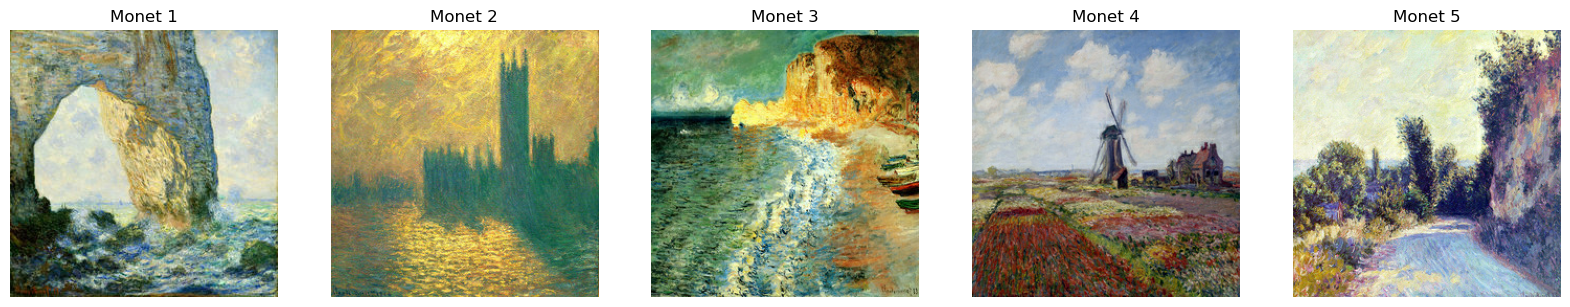

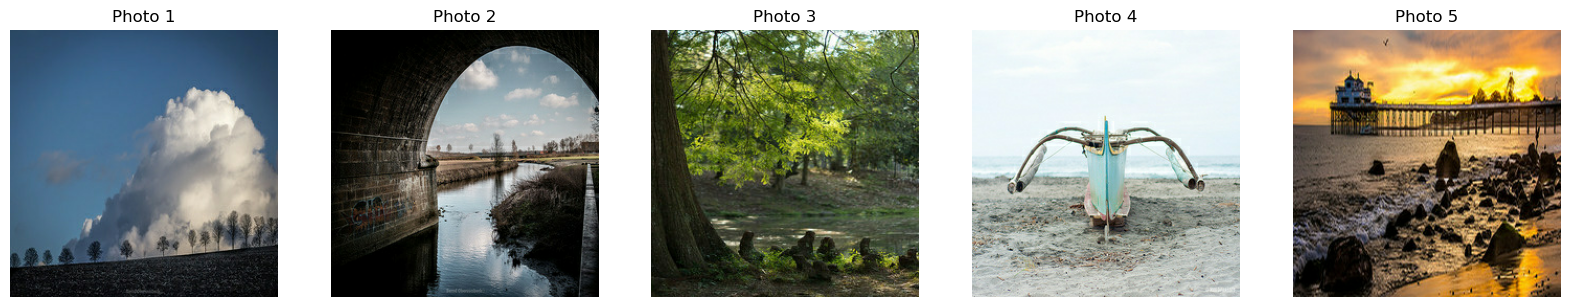

In [57]:
def display_samples(ds, title, samples = 5):
    plt.figure(figsize = (20, 8))
    for i, img in enumerate(ds.take(samples)):
        plt.subplot(1, samples, i + 1)
        plt.title(f'{title} {i + 1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

display_samples(monet_ds, 'Monet')
display_samples(photo_ds, 'Photo')

The dataset provides 300 Monet images and 7,038 photo images. It is distinctive that Monet paintings exhibit quite strong characteristics when compared to photos. Next, we will create and train a model to generate Monet-like photos, detailing how we achieve the objective.

# Step 3 : Model Architecutre

## 3.1 Model selection
Several GAN models are available, GAN, CycleGAN, Pix2Pix, StyleGAN, StarGAN and others. For this project, we have chosen to implement the CycleGAN while some of models required paired training samples. 


### CycleGAN
CycleGAN allows us the model designed for image-to-image translation tasks, enabling the transformation of images from one domain to another without paired training examples. It utilizes a cycle-consistency loss to ensure that the translation is coherent and can be reverted back to the original image.

It can learn to translate between two image domains without paired training data, which is a significant advantage in real-world scenarios where obtaining such pairs is often unfeasible.

CycleGAN is a pivotal model in unpaired image-to-image translation, designed to learn transformations between two distinct image domains, say Domain A and Domain B, without requiring corresponding pairs during training. It employs two generators and two discriminators, coupled with cycle-consistency loss, to facilitate high-quality and coherent translations between the domains.

### 3.1.1 CycleGAN

#### Buld the generator(UNET architecture)

Reduces the 2D dimensions of the image, using Conv2D layers, Instance Normalization, and LeakyReLU activation.

In [17]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

Increases the 2D dimensions of the image using Conv2DTranspose layers, Instance Normalization, and ReLU activation.

In [18]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

Concatenates the output of downsample layers to upsample layers symmetrically to bypass the vanishing gradient problem and outputs an image into the target domain.

In [21]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

2D image where higher pixel values indicate real classifications and lower values indicate fake classifications.

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [26]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

#### Build the CycleGAN model

In [28]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

#### Define loss functions

In [29]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [30]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [31]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [32]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

#### Train the CycleGAN

In [33]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Train the model (Epoch = 50)

In [71]:
with strategy.scope():
    cycle_gan_model_50 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model_50.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [72]:
cycle_gan_model_50.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50    
)

Epoch 1/50
300/300 [==============================] - 73s 209ms/step - monet_gen_loss: 2.5772 - photo_gen_loss: 2.7089 - monet_disc_loss: 0.6133 - photo_disc_loss: 0.5566
Epoch 2/50
300/300 [==============================] - 63s 210ms/step - monet_gen_loss: 2.5686 - photo_gen_loss: 2.7138 - monet_disc_loss: 0.5951 - photo_disc_loss: 0.5709
Epoch 3/50
300/300 [==============================] - 63s 210ms/step - monet_gen_loss: 2.6583 - photo_gen_loss: 2.8622 - monet_disc_loss: 0.5827 - photo_disc_loss: 0.5383
Epoch 4/50
300/300 [==============================] - 63s 210ms/step - monet_gen_loss: 2.5937 - photo_gen_loss: 2.7397 - monet_disc_loss: 0.5923 - photo_disc_loss: 0.5514
Epoch 5/50
300/300 [==============================] - 63s 210ms/step - monet_gen_loss: 2.5479 - photo_gen_loss: 2.6827 - monet_disc_loss: 0.6008 - photo_disc_loss: 0.5701
Epoch 6/50
300/300 [==============================] - 63s 211ms/step - monet_gen_loss: 2.5790 - photo_gen_loss: 2.7363 - monet_disc_loss: 0.5951 

300/300 [==============================] - 62s 206ms/step - monet_gen_loss: 2.5692 - photo_gen_loss: 2.7320 - monet_disc_loss: 0.5996 - photo_disc_loss: 0.5475
Epoch 49/50
300/300 [==============================] - 62s 206ms/step - monet_gen_loss: 2.5570 - photo_gen_loss: 2.6779 - monet_disc_loss: 0.5988 - photo_disc_loss: 0.5555
Epoch 50/50
300/300 [==============================] - 62s 206ms/step - monet_gen_loss: 2.5604 - photo_gen_loss: 2.6806 - monet_disc_loss: 0.5995 - photo_disc_loss: 0.5727


In [73]:
def plot_image():
    _, ax = plt.subplots(5, 2, figsize=(12, 12))
    for i, img in enumerate(photo_ds.take(5)):
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        ax[i, 0].imshow(img)
        ax[i, 1].imshow(prediction)
        ax[i, 0].set_title("Input Photo")
        ax[i, 1].set_title("Monet-esque")
        ax[i, 0].axis("off")
        ax[i, 1].axis("off")
    plt.show()

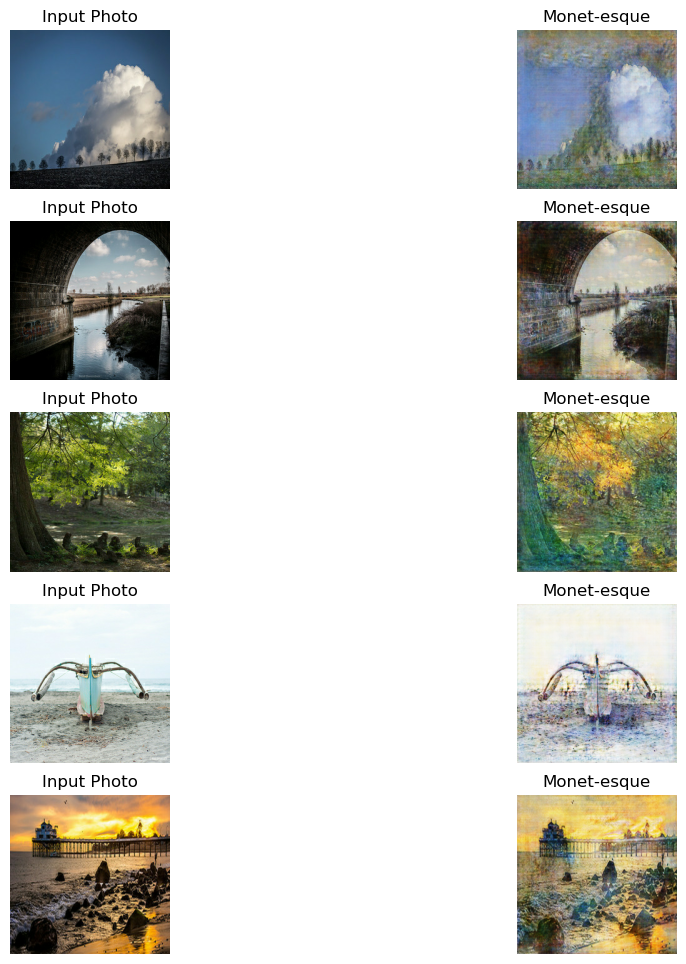

In [74]:
plot_image()

In [95]:
def generate_images(image_path):
    
    i = 1
    for img in photo_ds:
        prediction = monet_generator(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = PIL.Image.fromarray(prediction)
        im.save(image_path + str(i) + ".jpg")
        i += 1

In [96]:
generate_images('data/images_50/')

Kaggle score 44.54050

#### Train the model (Epoch = 100)

In [98]:
with strategy.scope():
    cycle_gan_model_100 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model_100.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [99]:
cycle_gan_model_100.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=100    
)

Epoch 1/100
300/300 [==============================] - 72s 208ms/step - monet_gen_loss: 2.5850 - photo_gen_loss: 2.6922 - monet_disc_loss: 0.5994 - photo_disc_loss: 0.5687
Epoch 2/100
300/300 [==============================] - 62s 208ms/step - monet_gen_loss: 2.5919 - photo_gen_loss: 2.7061 - monet_disc_loss: 0.5983 - photo_disc_loss: 0.5750
Epoch 3/100
300/300 [==============================] - 62s 208ms/step - monet_gen_loss: 2.5963 - photo_gen_loss: 2.7032 - monet_disc_loss: 0.5956 - photo_disc_loss: 0.5625
Epoch 4/100
300/300 [==============================] - 63s 209ms/step - monet_gen_loss: 2.5948 - photo_gen_loss: 2.6932 - monet_disc_loss: 0.6030 - photo_disc_loss: 0.5666
Epoch 5/100
300/300 [==============================] - 63s 209ms/step - monet_gen_loss: 2.5934 - photo_gen_loss: 2.6947 - monet_disc_loss: 0.5934 - photo_disc_loss: 0.5760
Epoch 6/100
300/300 [==============================] - 63s 209ms/step - monet_gen_loss: 2.6233 - photo_gen_loss: 2.7088 - monet_disc_loss: 0

300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 2.8525 - photo_gen_loss: 2.7054 - monet_disc_loss: 0.5211 - photo_disc_loss: 0.5815
Epoch 49/100
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 2.8731 - photo_gen_loss: 2.7155 - monet_disc_loss: 0.5271 - photo_disc_loss: 0.5691
Epoch 50/100
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 2.9026 - photo_gen_loss: 2.7201 - monet_disc_loss: 0.5058 - photo_disc_loss: 0.5735
Epoch 51/100
300/300 [==============================] - 56s 186ms/step - monet_gen_loss: 2.8823 - photo_gen_loss: 2.7553 - monet_disc_loss: 0.5373 - photo_disc_loss: 0.5788
Epoch 52/100
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 2.8696 - photo_gen_loss: 2.7258 - monet_disc_loss: 0.5421 - photo_disc_loss: 0.5767
Epoch 53/100
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 2.8504 - photo_gen_loss: 2.7288 - monet_disc_loss: 0.5329 -

300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.2793 - photo_gen_loss: 2.8321 - monet_disc_loss: 0.4521 - photo_disc_loss: 0.5569
Epoch 96/100
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.2345 - photo_gen_loss: 2.8492 - monet_disc_loss: 0.4894 - photo_disc_loss: 0.5752
Epoch 97/100
300/300 [==============================] - 57s 188ms/step - monet_gen_loss: 3.1845 - photo_gen_loss: 2.8184 - monet_disc_loss: 0.4938 - photo_disc_loss: 0.5664
Epoch 98/100
300/300 [==============================] - 57s 191ms/step - monet_gen_loss: 3.2433 - photo_gen_loss: 2.8348 - monet_disc_loss: 0.4633 - photo_disc_loss: 0.5664
Epoch 99/100
300/300 [==============================] - 57s 190ms/step - monet_gen_loss: 3.2229 - photo_gen_loss: 2.8406 - monet_disc_loss: 0.4731 - photo_disc_loss: 0.5651
Epoch 100/100
300/300 [==============================] - 57s 191ms/step - monet_gen_loss: 3.2328 - photo_gen_loss: 2.8384 - monet_disc_loss: 0.4605 

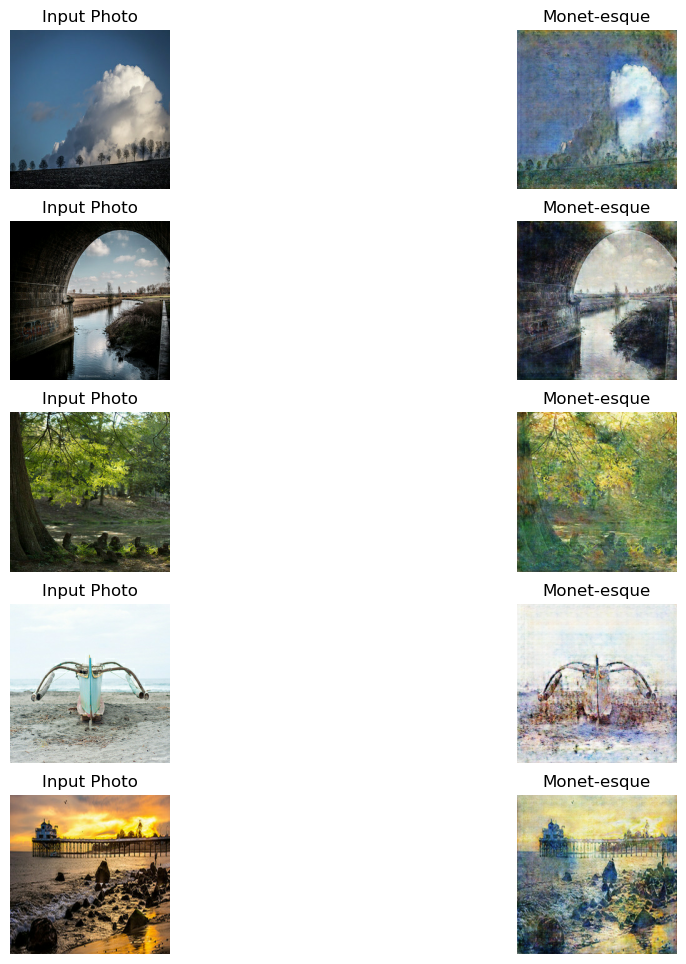

In [102]:
plot_image()

In [101]:
generate_images("data/images_100/")

Kgggle 45.41214

#### Train the model (Epoch = 400)

In [106]:
with strategy.scope():
    cycle_gan_model_400 = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model_400.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [107]:
cycle_gan_model_400.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=400    
)

Epoch 1/400
300/300 [==============================] - 66s 189ms/step - monet_gen_loss: 3.1040 - photo_gen_loss: 2.8345 - monet_disc_loss: 0.5567 - photo_disc_loss: 0.5589
Epoch 2/400
300/300 [==============================] - 57s 189ms/step - monet_gen_loss: 3.2017 - photo_gen_loss: 2.8390 - monet_disc_loss: 0.4619 - photo_disc_loss: 0.5659
Epoch 3/400
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 3.2234 - photo_gen_loss: 2.8498 - monet_disc_loss: 0.4948 - photo_disc_loss: 0.5634
Epoch 4/400
300/300 [==============================] - 57s 188ms/step - monet_gen_loss: 3.2707 - photo_gen_loss: 2.8580 - monet_disc_loss: 0.4467 - photo_disc_loss: 0.5692
Epoch 5/400
300/300 [==============================] - 57s 188ms/step - monet_gen_loss: 3.2736 - photo_gen_loss: 2.8569 - monet_disc_loss: 0.4786 - photo_disc_loss: 0.5554
Epoch 6/400
300/300 [==============================] - 57s 188ms/step - monet_gen_loss: 3.3099 - photo_gen_loss: 2.8858 - monet_disc_loss: 0

300/300 [==============================] - 57s 188ms/step - monet_gen_loss: 3.3745 - photo_gen_loss: 2.9551 - monet_disc_loss: 0.4823 - photo_disc_loss: 0.5427
Epoch 49/400
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 3.3726 - photo_gen_loss: 2.9517 - monet_disc_loss: 0.4914 - photo_disc_loss: 0.5587
Epoch 50/400
300/300 [==============================] - 57s 188ms/step - monet_gen_loss: 3.4313 - photo_gen_loss: 2.9637 - monet_disc_loss: 0.4415 - photo_disc_loss: 0.5517
Epoch 51/400
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 3.4998 - photo_gen_loss: 2.9979 - monet_disc_loss: 0.4455 - photo_disc_loss: 0.5491
Epoch 52/400
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 3.5154 - photo_gen_loss: 2.9912 - monet_disc_loss: 0.4466 - photo_disc_loss: 0.5557
Epoch 53/400
300/300 [==============================] - 56s 188ms/step - monet_gen_loss: 3.4088 - photo_gen_loss: 2.9735 - monet_disc_loss: 0.4901 -

300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.3036 - photo_gen_loss: 3.0129 - monet_disc_loss: 0.5540 - photo_disc_loss: 0.5382
Epoch 96/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.3011 - photo_gen_loss: 3.0194 - monet_disc_loss: 0.5017 - photo_disc_loss: 0.5557
Epoch 97/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.3949 - photo_gen_loss: 3.0382 - monet_disc_loss: 0.4520 - photo_disc_loss: 0.5474
Epoch 98/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.4269 - photo_gen_loss: 3.0322 - monet_disc_loss: 0.4754 - photo_disc_loss: 0.5476
Epoch 99/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.2912 - photo_gen_loss: 3.0328 - monet_disc_loss: 0.5866 - photo_disc_loss: 0.5463
Epoch 100/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.3655 - photo_gen_loss: 3.0535 - monet_disc_loss: 0.4625 

300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.3605 - photo_gen_loss: 3.0595 - monet_disc_loss: 0.4870 - photo_disc_loss: 0.5468
Epoch 143/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.3946 - photo_gen_loss: 3.0693 - monet_disc_loss: 0.4789 - photo_disc_loss: 0.5301
Epoch 144/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.4083 - photo_gen_loss: 3.0598 - monet_disc_loss: 0.4653 - photo_disc_loss: 0.5386
Epoch 145/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.4016 - photo_gen_loss: 3.0380 - monet_disc_loss: 0.4658 - photo_disc_loss: 0.5407
Epoch 146/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.5049 - photo_gen_loss: 3.0478 - monet_disc_loss: 0.4181 - photo_disc_loss: 0.5561
Epoch 147/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.5128 - photo_gen_loss: 3.0367 - monet_disc_loss: 0.4

300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.6366 - photo_gen_loss: 3.0821 - monet_disc_loss: 0.4208 - photo_disc_loss: 0.5476
Epoch 190/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.5435 - photo_gen_loss: 3.0695 - monet_disc_loss: 0.4572 - photo_disc_loss: 0.5326
Epoch 191/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.5961 - photo_gen_loss: 3.0891 - monet_disc_loss: 0.4667 - photo_disc_loss: 0.5427
Epoch 192/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.5532 - photo_gen_loss: 3.0680 - monet_disc_loss: 0.4266 - photo_disc_loss: 0.5232
Epoch 193/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.5748 - photo_gen_loss: 3.0674 - monet_disc_loss: 0.4112 - photo_disc_loss: 0.5337
Epoch 194/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.4064 - photo_gen_loss: 3.0755 - monet_disc_loss: 0.6

300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.7828 - photo_gen_loss: 3.1317 - monet_disc_loss: 0.4146 - photo_disc_loss: 0.5197
Epoch 237/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.7144 - photo_gen_loss: 3.1484 - monet_disc_loss: 0.4242 - photo_disc_loss: 0.5456
Epoch 238/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.7259 - photo_gen_loss: 3.1489 - monet_disc_loss: 0.4036 - photo_disc_loss: 0.5352
Epoch 239/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.6551 - photo_gen_loss: 3.1381 - monet_disc_loss: 0.4386 - photo_disc_loss: 0.5106
Epoch 240/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.6413 - photo_gen_loss: 3.1462 - monet_disc_loss: 0.4839 - photo_disc_loss: 0.5242
Epoch 241/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.7337 - photo_gen_loss: 3.1468 - monet_disc_loss: 0.3

300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.7434 - photo_gen_loss: 3.1857 - monet_disc_loss: 0.4060 - photo_disc_loss: 0.5151
Epoch 284/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.7258 - photo_gen_loss: 3.1882 - monet_disc_loss: 0.4332 - photo_disc_loss: 0.5286
Epoch 285/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8240 - photo_gen_loss: 3.1963 - monet_disc_loss: 0.3688 - photo_disc_loss: 0.5020
Epoch 286/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.8636 - photo_gen_loss: 3.2149 - monet_disc_loss: 0.3904 - photo_disc_loss: 0.5141
Epoch 287/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8036 - photo_gen_loss: 3.2253 - monet_disc_loss: 0.3938 - photo_disc_loss: 0.5443
Epoch 288/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8657 - photo_gen_loss: 3.1905 - monet_disc_loss: 0.3

300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8340 - photo_gen_loss: 3.2546 - monet_disc_loss: 0.4112 - photo_disc_loss: 0.5214
Epoch 331/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8919 - photo_gen_loss: 3.2307 - monet_disc_loss: 0.3903 - photo_disc_loss: 0.5099
Epoch 332/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8532 - photo_gen_loss: 3.2261 - monet_disc_loss: 0.3945 - photo_disc_loss: 0.4991
Epoch 333/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.9758 - photo_gen_loss: 3.2209 - monet_disc_loss: 0.3824 - photo_disc_loss: 0.4957
Epoch 334/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.9640 - photo_gen_loss: 3.2246 - monet_disc_loss: 0.3505 - photo_disc_loss: 0.5174
Epoch 335/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 3.8666 - photo_gen_loss: 3.2442 - monet_disc_loss: 0.4

300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 3.9758 - photo_gen_loss: 3.2659 - monet_disc_loss: 0.3851 - photo_disc_loss: 0.5291
Epoch 378/400
300/300 [==============================] - 56s 185ms/step - monet_gen_loss: 4.1022 - photo_gen_loss: 3.2430 - monet_disc_loss: 0.3618 - photo_disc_loss: 0.5043
Epoch 379/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 4.0178 - photo_gen_loss: 3.2397 - monet_disc_loss: 0.3759 - photo_disc_loss: 0.5028
Epoch 380/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 4.0940 - photo_gen_loss: 3.2594 - monet_disc_loss: 0.3391 - photo_disc_loss: 0.5162
Epoch 381/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 4.1097 - photo_gen_loss: 3.2497 - monet_disc_loss: 0.3731 - photo_disc_loss: 0.5358
Epoch 382/400
300/300 [==============================] - 55s 185ms/step - monet_gen_loss: 4.1377 - photo_gen_loss: 3.2257 - monet_disc_loss: 0.3

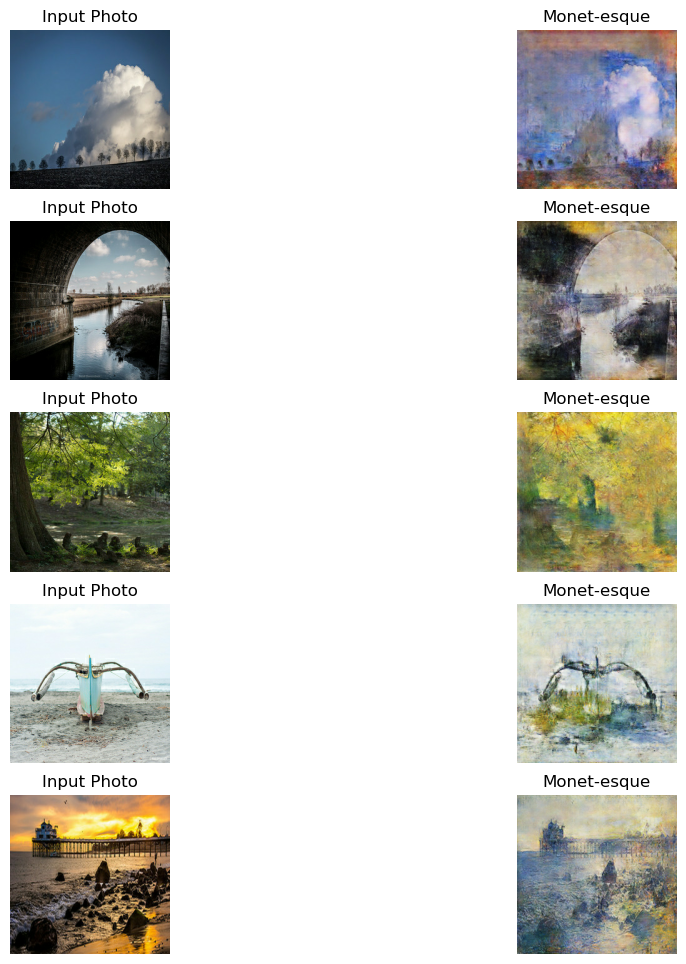

In [108]:
plot_image()

In [109]:
generate_images("data/images_400/")

Kgggle 75.82993

# Step 4 : Results and Analysis

In this step, we evaluate the performance of three models we have developed, each based on CycleGAN but trained with different numbers of epochs.

Evaluating art is a subjective topic, and there is no single solution for it. The models' submissions are evaluated on Memorization-informed Fréchet Inception Distance (MiFID), a modification of the Fréchet Inception Distance (FID). In this methodology, a smaller MiFID value is considered better, so we compare the distinction made by human eyes and the distinctions made by the MiFID methodology.

4.1 CycleGAN with epoch = 50

## 4.1 CycleGAN with epoch = 50

Our first attempt involved building the model with 50 epochs.

The generated images do not perfectly resemble Monet-style paintings to the human eye, but they appear to have achieved the goal to a certain extent. The Kaggle score for this model is 44.54050.


## 4.2 CycleGAN with epoch = 100

The model with epoch = 100 demonstrated more Monet-style characteristics, but some corruption was observed by human eyes. The Kaggle score for this model is 45.41214.

## 4.3 CycleGAN with epoch = 400

Larger corruption in the image was observed by human eyes. The Kaggle score for this model is 75.82993. Larger epochs did not show improvement, instead, the results deteriorated.

## 4.4 Analysis

We successfully transformed the pictures into Monet-style paintings using the CycleGAN model built in this project.

The Kaggle scores are as follows:

- CycleGAN, epoch = 50: 44.54050
- CycleGAN, epoch = 100: 45.41214 (Ranked 17 in the leaderboard)
- CycleGAN, epoch = 400: 75.82993

Losses of both the generator and the discriminator are important factors to assess the performance of the GAN models. The generator loss and discriminator loss typically have an inverse relationship; as the generator improves, the task becomes more challenging for the discriminator.

Upon examining the training epochs, it was observed that larger epochs showed better losses in the Monet Discriminator. This implies that the discriminator losses are reducing gradually, indicating that the model is fitting well. However, the generator losses fluctuated, implying that some constraints occurred during the modeling, and as a result, the final output is not perfect. This aligns with our visual inspections of the generated pictures.

# Step 5 : Conclusion

In conclusion, we explored Generative Adversarial Networks (GANs) and created a model by referring to tutorials, achieving the goal of building and training a GAN model and successfully generating Monet-style paintings from pictures. My submission ranked 17 on the Kaggle leaderboard. Choosing a model, tuning hyperparameters, and deciding on the appropriate number of epochs are always challenging, but we gained a lot from this assignment. In the future, we plan to train the model with other datasets, such as those containing Cezanne, Ukiyo-e, and Van Gogh paintings and deep dive into other GAN models and construct the model with favorable architecutre.

# Reference
- https://www.kaggle.com/competitions/gan-getting-started
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
- https://www.kaggle.com/c/generative-dog-images/overview/evaluation